In [60]:
import pandas as pd

In [61]:
df = pd.read_csv('../data/player_per_game.csv')
df.head()

,seas_id,season,player_id,player,birth_year,pos,age,experience,lg,tm,...,ft_percent,orb_per_game,drb_per_game,trb_per_game,ast_per_game,stl_per_game,blk_per_game,tov_per_game,pf_per_game,pts_per_game
0,31871.0,2025,5025.0,A.J. Green,NaN,SG,25.0,3,NBA,MIL,...,0.815,0.2,2.1,2.4,1.5,0.5,0.1,0.5,2.2,7.4
1,31872.0,2025,5026.0,A.J. Lawson,NaN,SG,24.0,3,NBA,TOR,...,0.683,0.8,2.5,3.3,1.2,0.5,0.2,0.6,1.7,9.1
2,31873.0,2025,5210.0,AJ Johnson,NaN,SG,20.0,1,NBA,TOT,...,0.865,0.3,1.8,2.0,2.6,0.4,0.1,1.2,1.7,7.6
3,31874.0,2025,5210.0,AJ Johnson,NaN,SG,20.0,1,NBA,MIL,...,0.500,0.0,1.0,1.0,1.0,0.1,0.0,0.6,0.0,2.9
4,31875.0,2025,5210.0,AJ Johnson,NaN,SG,20.0,1,NBA,WAS,...,0.886,0.4,2.0,2.4,3.1,0.5,0.1,1.4,2.3,9.1


In [62]:
#filter only 2025 season players
df = df[df['season'] == 2025]

#filter players with less than 15 games or less than 10 minutes a game
df = df[(df['g'] >= 15) & (df['mp_per_game'] >= 10)]

#aggregate duplicate player entries (mulitple due to player getting traded) 
df = df.copy()

df['weight'] = df['g'] #games played as weight

per_game_stats = [
    'pts_per_game', 'ast_per_game', 'trb_per_game',
    'stl_per_game', 'blk_per_game', 'tov_per_game',
    'fg_percent', 'x3p_percent', 'ft_percent',
    'fga_per_game', 'x3pa_per_game', 'mp_per_game'
]

#function to average stats
def weighted_avg(x):
    return (x[per_game_stats].multiply(x['weight'], axis=0).sum() / x['weight'].sum())

df = df.groupby(['player', 'player_id'], group_keys=False).apply(weighted_avg, include_groups=False).reset_index()

#check size of df
df.shape

(424, 14)

In [63]:
#keeping player name and id for future reference before dropping
reference_cols = ['player', 'player_id']

features = [
    'pts_per_game', 'ast_per_game', 'trb_per_game',
    'stl_per_game', 'blk_per_game', 'tov_per_game',
    'fg_percent', 'x3p_percent', 'ft_percent',
    'fga_per_game', 'x3pa_per_game'
]

df_cluster = df[reference_cols + features]


##fill nan cells with 0 
df_cluster.loc[:, 'x3p_percent'] = df_cluster['x3p_percent'].fillna(0)
df_cluster.loc[:, 'x3pa_per_game'] = df_cluster['x3pa_per_game'].fillna(0)

#check for any nan values
#df_cluster.isna().sum()

In [64]:
from sklearn.preprocessing import StandardScaler

features = [ 
    'pts_per_game', 'ast_per_game', 'trb_per_game',
    'stl_per_game', 'blk_per_game', 'tov_per_game',
    'fg_percent', 'x3p_percent', 'ft_percent',
    'fga_per_game', 'x3pa_per_game'
]

X = df[features]

#scale data so all stats contribute equally to clustering
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [65]:
#elbow method to find best value for k(number of clusters)
'''
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt


inertia = []
K = range(2, 11) #trying different values for k

for k in K: 
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(K, inertia, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow method: Optimal Number of Clusters')
plt.grid(True)
plt.show()

#didnt show clear indication of k value
'''

"\nfrom sklearn.cluster import KMeans\nimport matplotlib.pyplot as plt\n\n\ninertia = []\nK = range(2, 11) #trying different values for k\n\nfor k in K: \n    kmeans = KMeans(n_clusters=k, random_state=42)\n    kmeans.fit(X_scaled)\n    inertia.append(kmeans.inertia_)\n\nplt.figure(figsize=(8, 5))\nplt.plot(K, inertia, marker='o')\nplt.xlabel('Number of clusters (k)')\nplt.ylabel('Inertia')\nplt.title('Elbow method: Optimal Number of Clusters')\nplt.grid(True)\nplt.show()\n\n#didnt show clear indication of k value\n"

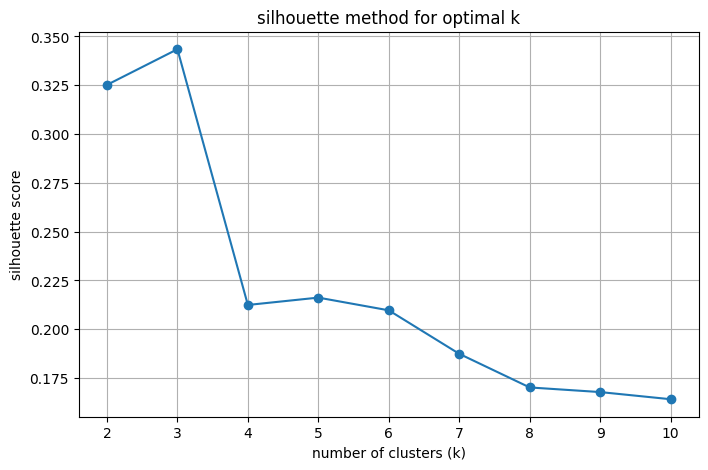

In [66]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

silhouette_scores = []
K = range(2, 11) 

for k in K: 
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    silhouette_scores.append(score)

plt.figure(figsize=(8, 5))
plt.plot(K, silhouette_scores, marker='o')
plt.xlabel('number of clusters (k)')
plt.ylabel('silhouette score')
plt.title('silhouette method for optimal k')
plt.grid(True)
plt.show()

In [67]:
#graph shows best silhouette score to be k=3, quality decreases after

kmeans = KMeans(n_clusters=3, random_state=42)
df['cluster'] = kmeans.fit_predict(X_scaled)

In [68]:
#assign archetype labels
cluster_labels = { 
    0: 'Rebounder',
    1: 'Role Player',
    2: 'Star'
}

#map cluster to archetype label
df['archetype'] = df['cluster'].map(cluster_labels)

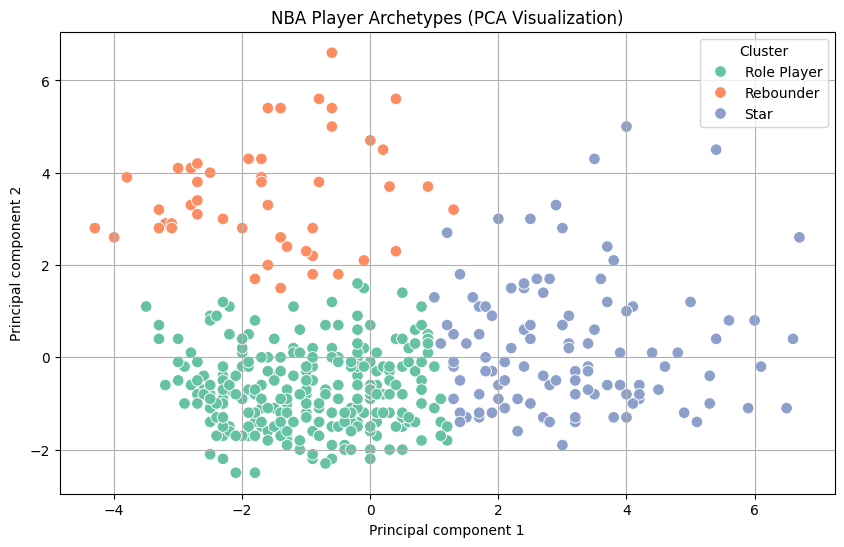

In [69]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

#reduce to 2D for visual
pca = PCA(n_components=2)
pca_components = pca.fit_transform(X_scaled)

#add pca results to df for plotting
df['pca1'] = pca_components[:, 0]
df['pca2'] = pca_components[:, 1]

#rounding to nearest decimal point
df = df.round(1)

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='pca1', y='pca2', hue='archetype', palette='Set2', s=70)
plt.title('NBA Player Archetypes (PCA Visualization)')
plt.xlabel('Principal component 1')
plt.ylabel('Principal component 2')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

In [70]:
#check avg stats of each cluster
df.groupby('cluster')[[
    'pts_per_game', 'ast_per_game', 'trb_per_game',
    'stl_per_game', 'blk_per_game', 'tov_per_game',
    'fg_percent', 'x3p_percent', 'ft_percent',
    'fga_per_game', 'x3pa_per_game'
]].mean().round

<bound method DataFrame.round of          pts_per_game  ast_per_game  trb_per_game  stl_per_game  blk_per_game  \
cluster                                                                         
0            8.279167      1.608333      6.870833      0.631250      0.989583   
1            7.813806      1.831343      3.175000      0.694403      0.330970   
2           19.679630      4.732407      5.726852      1.121296      0.615741   

         tov_per_game  fg_percent  x3p_percent  ft_percent  fga_per_game  \
cluster                                                                    
0            1.091667    0.608333     0.100000    0.660417      5.789583   
1            0.919403    0.443284     0.351493    0.771642      6.414552   
2            2.387963    0.464815     0.359259    0.809259     15.106481   

         x3pa_per_game  
cluster                 
0             0.329167  
1             3.188433  
2             5.979630  >

In [71]:
#sample players
for label in df['cluster'].unique():
    archetype = cluster_labels[label]
    print(f"\n--- Archetype: {archetype} ---")
    print(df[df['cluster'] == label][['player', 'pts_per_game', 'ast_per_game', 'trb_per_game', 'x3p_percent']].sample(5))


--- Archetype: Role Player ---
                       player  pts_per_game  ast_per_game  trb_per_game  \
337               Patty Mills           4.0           1.0           0.9   
373         Spencer Dinwiddie          11.0           4.4           2.6   
224             Jose Alvarado          10.3           4.6           2.4   
250  Kentavious Caldwell-Pope           8.7           1.8           2.2   
10                 Alec Burks           7.3           1.1           2.5   

     x3p_percent  
337          0.3  
373          0.3  
224          0.4  
250          0.3  
10           0.4  

--- Archetype: Rebounder ---
               player  pts_per_game  ast_per_game  trb_per_game  x3p_percent
342  Precious Achiuwa           6.6           1.0           5.6          0.3
119   Donovan Clingan           6.5           1.1           7.9          0.3
239         Kai Jones           5.0           0.6           3.1          0.2
207      Jericho Sims           1.7           0.6           3.5  

In [72]:
#Query a player's archetype
def get_archetype(player_name):
    result = df[df['player'].str.contains(player_name, case=False)]
    return result[['player', 'archetype', 'pts_per_game', 'ast_per_game', 'trb_per_game', 'stl_per_game', 'blk_per_game', 'tov_per_game', 'fg_percent', 'x3p_percent', 'ft_percent', 'fga_per_game', 'x3pa_per_game']]

get_archetype("lebron james")

,player,archetype,pts_per_game,ast_per_game,trb_per_game,stl_per_game,blk_per_game,tov_per_game,fg_percent,x3p_percent,ft_percent,fga_per_game,x3pa_per_game
275,LeBron James,Star,24.4,8.2,7.8,1.0,0.6,3.7,0.5,0.4,0.8,18.1,5.7
